In [1]:
import tensorflow
from tensorflow import keras
from keras.datasets import boston_housing
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()
print(f"Data shape = {train_data.shape}")
print(f"Data sample = {train_data[0]}, size of this sample = {len(train_data[0])} features")
print(f"Label sample = ${train_labels[0]} * 1000")
print(f"Test Data shape = {test_data.shape}")
print(f"House prices: min = {np.min(train_labels)}, max = {np.max(train_labels)}. Mean price = {np.mean(train_labels)}, median price = {np.median(train_labels)}")

Data shape = (404, 13)
Data sample = [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ], size of this sample = 13 features
Label sample = $15.2 * 1000
Test Data shape = (102, 13)
House prices: min = 5.0, max = 50.0. Mean price = 22.395049504950492, median price = 20.75


In [3]:
# # Feature normalization
# train_data_means = train_data.mean(axis=0)
# train_data -= train_data_means
# test_data -= train_data_means
# train_data_stddevs = train_data.std(axis=0)
# train_data /= train_data_stddevs
# test_data /= train_data_stddevs

In [4]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

In [5]:
k = 4 
num_val_samples = len(train_data) // k
num_epochs = 100 
num_epochs = 500 
all_mae_histories = [] 
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_labels = np.concatenate(
        [train_labels[:i * num_val_samples],
         train_labels[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_labels,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-07 06:43:47.229270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-07 06:43:47.229376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-07 06:43:47.272117: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-07 06:43:47.463063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 06:43:47.804624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

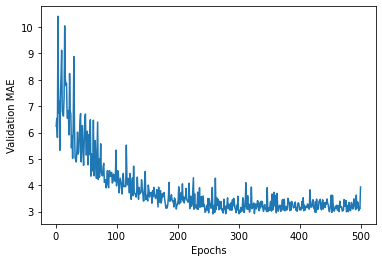

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

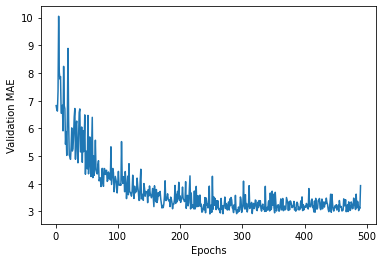

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [ ]:
model = build_model()
model.fit(train_data, train_labels,
          epochs=300, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_labels)
print(test_mae_score)

2022-03-07 06:41:44.659789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step - loss: 32.6916 - mae: 3.8759
3.875865936279297


2022-03-07 06:42:20.013852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
predictions = model.predict(test_data)
predictions[0]

2022-03-07 06:32:49.797332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([7.039904], dtype=float32)

test_mae_score = 2.307 with optimal parameters with feature normalization.
test_mae_score = 4.727 with same parameters with NO feature normalization.
test_mae_score = 3.876 with optimal parameters with NO feature normalization.

`Tuned params for normed: epochs=130, batch_size=16`

`Tuned params for NOT normed: epochs=300, batch_size=16`

So house price predictions are off by 2.3k with normalization, and a whopping 4.7k or even 3.86k without it!

But what if we made the model bigger to see if it learns to normalize by itself? So a layer deeper, and a bit broader.

----

Separately, what would happen if the last linear layer is replaced by a sigmoid activated layer?
=> THe model seems to not learn at all. The MAE is absolutely constant and flat over 500 epochs.
